# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## Analysis

### Data Exploration - Data Visualisation

In [1]:
# import the relevant libraries
import pandas as pd
import numpy as np
import math
import json
import time
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import r2_score,make_scorer
from sklearn.svm import SVR
% matplotlib inline



In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
# A thorough look at the various offers
portfolio.head(10)


,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [4]:
# First look at the profile dataset (customers demographic data). 
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [5]:
# Some missing data identified above so the info below should give us further information on that
# As we can see there are 17000 customers in total but only 14825 of them have 'income' and 'gender' fields completed
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [6]:
# Further investigation on gender. There is a value for 'Other' available apart from the null ones
profile.gender.unique()

array([None, 'F', 'M', 'O'], dtype=object)

In [7]:
print('There are '+str(sum(pd.isna(profile.gender)))+' records missing gender and '+str((17000-sum(pd.isna(profile.gender))))+' records that do not.')


There are 2175 records missing gender and 14825 records that do not.


In [8]:
# As per the description of the file above, any missing age has been filled with a value of 118.
# Could it be the same customer who miss income and gender? Let's filter on them.

profile_missing_age=profile[profile.age==118]
print(profile_missing_age.head())
print('')
print(profile_missing_age.info())

   age  became_member_on gender                                id  income
0  118          20170212   None  68be06ca386d4c31939f3a4f0e3dd783     NaN
2  118          20180712   None  38fe809add3b4fcf9315a9694bb96ff5     NaN
4  118          20170804   None  a03223e636434f42ac4c3df47e8bac43     NaN
6  118          20170925   None  8ec6ce2a7e7949b1bf142def7d0e0586     NaN
7  118          20171002   None  68617ca6246f4fbc85e91a2a49552598     NaN

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 16994
Data columns (total 5 columns):
age                 2175 non-null int64
became_member_on    2175 non-null int64
gender              0 non-null object
id                  2175 non-null object
income              0 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 102.0+ KB
None


### Conclusion 1:
##### The info above clearly shows that there are 2175 people 'aged 118', just as many as those missing gender and income and this subset has no gender or income values.

###### Therefore, these customers will be excluded from our study as there is no demographic data about them. 

#### Before we start doing some visualisation let's create some functions that will help as with that 

In [9]:
def aggr_table(df,x):
    """Creates count,cumulative count and the equivalent % columns for a specific field in a df

    Args:
    df: The dataframe
    x: string. The column in the dataframe we group by

    Returns:
    A table with count, cumulative count, count% and cumulative count% for the given column.
    """
    
    aggr=df.groupby(x).size().reset_index(name='Count')    # Create the groupby and the first metric
    cum_name='Cumulative Count'   # Name of the second metric created
    cum_name_per_cent=cum_name+' %'    # Name of the third metric created
    y_per_cent='Count %'    # Will be used as the name of the fourth metric
    aggr[cum_name]=aggr['Count'].cumsum()    # Cumulative count created
    aggr[y_per_cent]=round(100*aggr['Count']/sum(aggr['Count']),1)    # Count %
    aggr[cum_name_per_cent]=round(100*aggr[cum_name]/sum(aggr['Count']),1)    # Cumulative count %
    
    
    return aggr

def metric_convert(metric):
    """This function will be used for the function below. It just saves the user from submitting long argument names

    Args:
    metric: string.The argument that will be passed in the function aggr_graph below.Values accepted: 
    
    Returns:
    The full name of the metric
    """
    
    if metric=='Cum Count':
        metric='Cumulative Count'
        
    elif metric=='Cum Count %':
        metric='Cumulative Count %'
     
    elif metric=='Count' or metric=='Count %':
        metric=metric
    
    else: 
        print('Please give a valid metric name')
        sys.exit()
    
    return metric     


def aggr_graph(df,x,metric,kind,show_val=False,h_line=None,return_table=False,sort=False,ascend=True):
    """Creates a graph for a specific feature of a dataframe following a specific metric

    Args:
    df: The dataframe
    x: The feature being visualised (string)
    metric: The metric used in the visualisation. Accepted values are the below ONLY:
            'Count','Count %','Cum Count' for Cumulative Count and 'Cum Count %' for Cumulative Count %
    kind: The kind of plot. Please give one of these ONLY: 'pie','line' or 'bar'.
    show_val: If True, the values of the feature will appear in the graph. 
    h_line: Optional. Creates horizontal line
    return_table: If True it will also provide the table of the values in the graph
    sort: For bar chart ONLY: If True it will sort the bars by value rather than alphabetically.
    ascend: Use it only if sort argument is True. It's the order by which bars will be sorted. Use True for ascending
    
    Returns:
    The graph. Pie chart, bar chart or line graph.
    """
        
    
    aggr=aggr_table(df,x)    # The aggregate by this feature created. 
    if sort:
        aggr=aggr.sort_values(by='Count',ascending=ascend)    # Aggr table sorted if needed
        
    
    if kind=='pie':
        aggr.plot(kind=kind, y=metric, labels=aggr[x], autopct='%1.1f%%')    # Pie chart created
        title='Distribution of '+x
    elif kind=='line' or kind=='bar':
        metric=metric_convert(metric)    # Function above used to convert the metric to its full name
        aggr.plot(x=x,y=metric,kind=kind)    # The line graph of bar chart created
        
        # Labels created in the following 3 lines
        plt.xlabel(x)     
        plt.ylabel(metric)    
        title='Count of Customers by '+x

        # If statements below create horizontal line and show the values if requested 
        if h_line is not None:
            plt.axhline(y=h_line, color='r', linestyle='--')
        if show_val:
            for i, value in enumerate(aggr[metric]):
                plt.text(i, value, str(value), ha='center', va='bottom')
        
    plt.title(title)    # Title added
        
    plt.show()    # Display the chart
    
    # Table with values appears below the graph if requested
    if return_table:
        return aggr



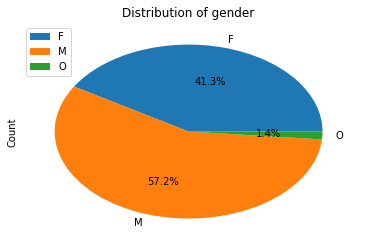

,gender,Count,Cumulative Count,Count %,Cumulative Count %
0,F,6129,6129,41.3,41.3
1,M,8484,14613,57.2,98.6
2,O,212,14825,1.4,100.0


In [10]:
# Distribution of genders
aggr_graph(profile,'gender','Count','pie',return_table=True)

### Conclusion 2:
#####  Value 'Other' represents 1.4% or 212 people only therefore doesn't help in inference. 
##### These customer will be randomly allocated to the other two genders based on the proportion of the latter 

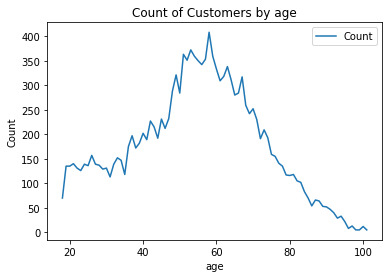

,age,Count,Cumulative Count,Count %,Cumulative Count %
0,18,70,70,0.5,0.5
1,19,135,205,0.9,1.4
2,20,135,340,0.9,2.3
3,21,140,480,0.9,3.2
4,22,131,611,0.9,4.1
5,23,126,737,0.8,5.0
6,24,139,876,0.9,5.9
7,25,136,1012,0.9,6.8
8,26,157,1169,1.1,7.9
9,27,139,1308,0.9,8.8


In [11]:
# Distribution of age
aggr_graph(profile[profile.age!=118],'age','Count','line',return_table=True)

#### Most people are in the age range 50-70 with equal tails on either side. Perhaps age should be split in 3 equal ranges. 

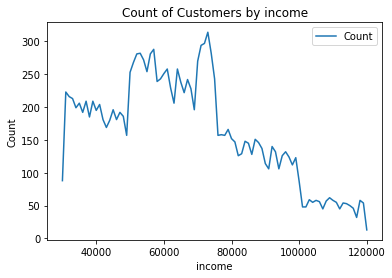

,income,Count,Cumulative Count,Count %,Cumulative Count %
0,30000.0,88,88,0.6,0.6
1,31000.0,223,311,1.5,2.1
2,32000.0,216,527,1.5,3.6
3,33000.0,213,740,1.4,5.0
4,34000.0,199,939,1.3,6.3
5,35000.0,206,1145,1.4,7.7
6,36000.0,192,1337,1.3,9.0
7,37000.0,209,1546,1.4,10.4
8,38000.0,185,1731,1.2,11.7
9,39000.0,209,1940,1.4,13.1


In [12]:
# Finally, distribution of graph
aggr_graph(profile,'income','Count','line',return_table=True)

In [13]:
# Let's see the biggest and most informative file 
# No null values here so nothing to be discarded at the moment
print(transcript.info())
print(transcript.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB
None
            event                            person  time  \
0  offer received  78afa995795e4d85b5d9ceeca43f5fef     0   
1  offer received  a03223e636434f42ac4c3df47e8bac43     0   
2  offer received  e2127556f4f64592b11af22de27a7932     0   
3  offer received  8ec6ce2a7e7949b1bf142def7d0e0586     0   
4  offer received  68617ca6246f4fbc85e91a2a49552598     0   

                                              value  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}  


In [14]:
# Number of customers as many as in the profile df
transcript.person.nunique()

17000

In [15]:
# As per the description of the experiment above we should expect a time range of 30 days
print('Time start: ',transcript.time.min())
print('Time end: ',transcript.time.max())
print('Total time (hours): ',transcript.time.max()-transcript.time.min())
print('Total time (days): ',(transcript.time.max()-transcript.time.min())/24)

Time start:  0
Time end:  714
Total time (hours):  714
Total time (days):  29.75


In [16]:
# Four event types as expected
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

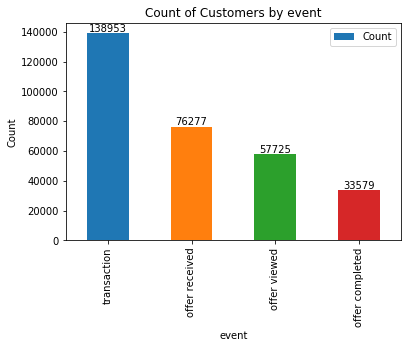

,event,Count,Cumulative Count,Count %,Cumulative Count %
3,transaction,138953,306534,45.3,100.0
1,offer received,76277,109856,24.9,35.8
2,offer viewed,57725,167581,18.8,54.7
0,offer completed,33579,33579,11.0,11.0


In [17]:
# Distribution of events
aggr_graph(transcript,'event','Count','bar',show_val=True,return_table=True,sort=True,ascend=False)

#### Some inferences:
#####  1. Most frequent event is transaction. Obviously a lot of transactions occur independently of offers. That needs to be reported. 
#####  2. Offers received are not always viewed. Even the latter are not always completed. View Rate and Conversion rate are two very important measures
#####  3. If any of the 17000 customers have not received any offer at all they need to be removed.

In [18]:
# Let's take a closer look at the most active customer. Column value needs to be interpreted
transcript[(transcript.person==transcript.groupby('person').size().idxmax())]

,event,person,time,value
2276,offer received,94de646f7b6041228ca7dec82adb97d2,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
16010,offer viewed,94de646f7b6041228ca7dec82adb97d2,6,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
24531,transaction,94de646f7b6041228ca7dec82adb97d2,30,{'amount': 7.41}
24532,offer completed,94de646f7b6041228ca7dec82adb97d2,30,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...
42252,transaction,94de646f7b6041228ca7dec82adb97d2,102,{'amount': 1.47}
55475,offer received,94de646f7b6041228ca7dec82adb97d2,168,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
75256,offer viewed,94de646f7b6041228ca7dec82adb97d2,186,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
77624,transaction,94de646f7b6041228ca7dec82adb97d2,192,{'amount': 2.62}
81725,transaction,94de646f7b6041228ca7dec82adb97d2,204,{'amount': 0.59}
93913,transaction,94de646f7b6041228ca7dec82adb97d2,246,{'amount': 2.2800000000000002}


#### Some inferences here:
##### 1. In the first 4 rows we saw that this person received an offer which they viewed soon after and converted 24 hours later by buying a $7.41 product
##### 2. From time 276 to 330 though they made a few transactions without having received an order which indicates that this may be a loyal customer anyway.
##### 3. At time 336 they received an offer which they never viewed however it was completed at time 492 as they spent the required money anyway. This will not count as a converted offer.

In [19]:
# The value of offer completed is not fully visible above. This line of code will split it.
transcript[(transcript.person==transcript.groupby('person').size().idxmax())&(transcript.event=='offer completed')].iloc[0,3]

# It shows the offer id and the reward associated with this offer. 

{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d', 'reward': 5}

In [20]:
# Column value is being splitted here
warnings.filterwarnings("ignore")

transcript['offer_id'] = transcript['value'].apply(lambda x: x.get('offer id') or x.get('offer_id') if ('offer id' in x) or ('offer_id' in x) else None)
transcript['amount'] = transcript['value'].apply(lambda x: x.get('amount') if 'amount' in x else None)
transcript['reward'] = transcript['value'].apply(lambda x: x.get('reward') if 'reward' in x else None)
transcript.drop('value',axis=1)

,event,person,time,offer_id,amount,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN
5,offer received,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN
6,offer received,c4863c7985cf408faee930f111475da3,0,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,NaN,NaN
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
9,offer received,31dda685af34476cad5bc968bdb01c53,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN


In [21]:
# As mentioned above we need to look for people without any offer received.
print('There are',transcript[transcript.person.isin(transcript[(transcript.event=='offer received')].person)==False].person.nunique(),'people who never received an offer so they will be excluded from our study')



There are 6 people who never received an offer so they will be excluded from our study


## Methodology

### Data preprocessing

In [22]:
# Let's keep a copy of the initial profile dataset in case it is needed later.
# As we can see below the 2175 customers we were taking about above have been removed

profile_unclean=profile
profile.dropna(inplace=True)
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
age                 14825 non-null int64
became_member_on    14825 non-null int64
gender              14825 non-null object
id                  14825 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 694.9+ KB


In [23]:
# The proportion of 'Male' relative to 'Female' in the profile dataset is calculated.
gender_aggr=aggr_table(profile,'gender')

prob_m=int(gender_aggr[gender_aggr.gender =='M']['Count'])/(int(gender_aggr[gender_aggr.gender =='M']['Count'])+int(gender_aggr[gender_aggr.gender =='F']['Count']))
prob_m

0.580578936563334

In [24]:
import random    # Library used for random assignments

# The function below randomly assigns gender 'Other' to 'Male' or 'Female' in a proportion 58 (prob_m) to 42. 
def gender_rectify(gender):
    values = ['M', 'F']
    probabilities = [prob_m, 1-prob_m]
    
    def rectify(gen):
        if gen == 'O':
            return random.choices(values, probabilities)[0]
        return gen
    
    return gender.apply(rectify)

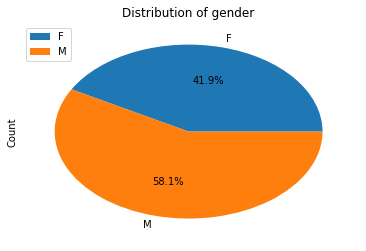

,gender,Count,Cumulative Count,Count %,Cumulative Count %
0,F,6216,6216,41.9,41.9
1,M,8609,14825,58.1,100.0


In [25]:
# Function applied here
profile['gender']=gender_rectify(profile['gender'])

# Fresh gender visualisation created here.
# As we can see the proportion of the two present genders is just about what we expected
aggr_graph(profile,'gender','Count','pie',return_table=True)

In [26]:
# Keep a record of initial transcript file
transcript_unclean=transcript

In [27]:
# As mentioned above only the people that have received at least one offer should remain. 
# Remember we identified 6 people that need to be removed so we expect to have 16994 customers after that.

transcript=transcript[transcript.person.isin(transcript[(transcript.event=='offer received')].person.unique())]

print(transcript.info())
print('')
print('Number of people in the study:'+str(transcript.person.nunique()))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306514 entries, 0 to 306533
Data columns (total 7 columns):
event       306514 non-null object
person      306514 non-null object
time        306514 non-null int64
value       306514 non-null object
offer_id    167581 non-null object
amount      138933 non-null float64
reward      33579 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 18.7+ MB
None

Number of people in the study:16994


In [28]:
# We have already removed 2175 customers from profile dataset. 
# They need to be removed from here too (unless any of them was among the 6 already removed)

transcript=transcript[transcript['person'].isin(profile['id'])]
print('Number of people in the study:'+str(transcript.person.nunique()))

Number of people in the study:14820


##### It seems that 16994-14820=2174 people were removed, so one of those to be removed was in the 6 discarded earlier.

In [29]:
# Let's check the consistemcy of data:

# Records with no amount or reward either should be associated with offers received or viewed 
print(transcript[(pd.isnull(transcript.amount))&(pd.isnull(transcript.reward))].event.unique())

# Records with no amount but with reward should be associated with offers completed 
print(transcript[(pd.isnull(transcript.amount))&(pd.isnull(transcript.reward)==False)].event.unique())

# Records with an amount but with no reward should be associated with transactions. 
print(transcript[(pd.isnull(transcript.amount)==False)&(pd.isnull(transcript.reward))].event.unique())
print('')

transcript.info()

['offer received' 'offer viewed']
['offer completed']
['transaction']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272743 entries, 0 to 306532
Data columns (total 7 columns):
event       272743 non-null object
person      272743 non-null object
time        272743 non-null int64
value       272743 non-null object
offer_id    148805 non-null object
amount      123938 non-null float64
reward      32444 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 16.6+ MB


In [30]:
# As we have removed some people without received orders from transcript dataset they need to be removed from
# profile dataset as well. Easiest way is to only keep people that are present in transcript

profile=profile[profile.id.isin(transcript.person.unique())]
print('Number of people in profile dataset:',profile.id.nunique())
print('')
profile.info()

Number of people in profile dataset: 14820

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14820 entries, 1 to 16999
Data columns (total 5 columns):
age                 14820 non-null int64
became_member_on    14820 non-null int64
gender              14820 non-null object
id                  14820 non-null object
income              14820 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 694.7+ KB


In [31]:
# Add portfolio data to transcript one
transcript = pd.merge(transcript, portfolio, left_on='offer_id', right_on='id',how='left')
transcript.head()



,event,person,time,value,offer_id,amount,reward_x,channels,difficulty,duration,id,offer_type,reward_y
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,"[web, email, mobile]",5.0,7.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0
1,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN,"[web, email, mobile]",10.0,7.0,2906b810c7d4411798c6938adc9daaa5,discount,2.0
2,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,"[web, email, mobile, social]",5.0,5.0,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5.0
3,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed,NaN,NaN,"[web, email, mobile]",0.0,4.0,3f207df678b143eea3cee63160fa8bed,informational,0.0
4,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,"[web, email]",20.0,10.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5.0


In [32]:
# Clean the table
transcript = transcript.rename(columns={'reward_x': 'reward_completed','reward_y': 'reward_offered'}).drop('id',axis=1)

transcript.head()

,event,person,time,value,offer_id,amount,reward_completed,channels,difficulty,duration,offer_type,reward_offered
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,"[web, email, mobile]",5.0,7.0,bogo,5.0
1,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN,"[web, email, mobile]",10.0,7.0,discount,2.0
2,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,"[web, email, mobile, social]",5.0,5.0,bogo,5.0
3,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed,NaN,NaN,"[web, email, mobile]",0.0,4.0,informational,0.0
4,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,"[web, email]",20.0,10.0,discount,5.0


In [33]:
# The table is sorted here by person and time. 

# In case of two events at the same time for a person the priority of events is as in the line below: 
priority_order = {'offer received': 1,'offer viewed': 2,'transaction': 3,'offer completed': 4}

transcript['priority_num'] = transcript['event'].map(priority_order)

transcript = transcript.sort_values(by=['person','time','priority_num']).reset_index().drop(['index','priority_num'],axis=1)

transcript.head(10)


,event,person,time,value,offer_id,amount,reward_completed,channels,difficulty,duration,offer_type,reward_offered
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,"[email, mobile, social]",0.0,3.0,informational,0.0
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,"[email, mobile, social]",0.0,3.0,informational,0.0
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},None,22.16,NaN,NaN,NaN,NaN,NaN,NaN
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed,NaN,NaN,"[web, email, mobile]",0.0,4.0,informational,0.0
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed,NaN,NaN,"[web, email, mobile]",0.0,4.0,informational,0.0
5,offer received,0009655768c64bdeb2e877511632db8f,408,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,"[web, email, mobile, social]",5.0,5.0,bogo,5.0
6,transaction,0009655768c64bdeb2e877511632db8f,414,{'amount': 8.57},None,8.57,NaN,NaN,NaN,NaN,NaN,NaN
7,offer completed,0009655768c64bdeb2e877511632db8f,414,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,"[web, email, mobile, social]",5.0,5.0,bogo,5.0
8,offer viewed,0009655768c64bdeb2e877511632db8f,456,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,"[web, email, mobile, social]",5.0,5.0,bogo,5.0
9,offer received,0009655768c64bdeb2e877511632db8f,504,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,"[web, email, mobile, social]",10.0,10.0,discount,2.0


In [34]:
# WARNING: This step takes around 1h20min to run due to the bulk of calculations

# Main part of preprocessing takes place here:

# 1. Any offers received, viewed and finally completed are marked as converted

# 2. In the offer_id field where event is transaction, the NaN value is replaced with Offer-Related (if it counts
#    towards a completed offer) or Non-offer related (otherwise)

# 3.Transaction gap field is created and counts the time between two consecutive transaction. Will be used later
#   for the creation of a field that shows non-offer daily spending 

warnings.filterwarnings("ignore")

# Two relevant fields created and are currently 0.
transcript['converted'] = 0
transcript['transaction_gap'] = 0

# Loop through all 14820 customers.
for person in transcript['person'].unique():
    
    person_rows = transcript[transcript['person'] == person]    # A subset by person is created
    offer_id = None 
    trans_start_time=0
    
    # Loop through all rows in the person
    for index, row in person_rows.iterrows():
        
        if row['event'] == 'offer viewed':    # The first row where an offer has been viewed is identified
            offer_id = row['offer_id']    # Store the offer_id    
            index_start=index    # Store the index
            offer_type=row['offer_type']    # Also store the offer type
            
            person_rows_view=person_rows.loc[index_start+1:]    # For this person look at all rows below this offer viewed
            
            # Loop through these rows to see if the offer above was converted 
            for index, row in person_rows_view.iterrows(): 
                
                # Criterion for conversion is whether somewhere below there is a row for completed offer with this offer_id.
                if row['event'] == 'offer completed' and row['offer_id'] == offer_id:
                    index_end=index
                    transcript.loc[transcript.index == index_end,'converted']=1    # For this row ONLY column converted=1
                    
                    # Since offer was converted, several rows showing transaction before completion should be marked as Offer-Related
                    # In the case of bogo it's only the last one (one-off)
                    if offer_type=='bogo':
                        transcript.loc[(transcript.index == index_end-1) & (transcript['event'] == 'transaction'), 'offer_id'] = 'Offer Related'
                        break
                    
                    # In the case of discount it's all rows between vieweing and completion that have contributed
                    elif offer_type=='discount':
                        transcript.loc[(transcript.index >= index_start+1) & (transcript.index <= index_end-1) & (transcript['event'] == 'transaction'), 'offer_id'] = 'Offer Related'
                        break
                        
    # The loop below counts the time between consecutive transactions
    for index, row in person_rows.iterrows():
        if row['event'] == 'transaction':
            transcript.loc[transcript.index == index,'transaction_gap']=row['time']-trans_start_time
            trans_start_time=row['time']
                    
        

    # Bogo and discount can be clearly identified as there would be a record 
    # showing 'offer completed' for a spedific order_id    
    
    # For informational ones though there is no such record for completion 
    # as they don't require any certain amount spent
    
    # The logic is: Mark any bogo or discount related transactions as offer-related and then look
    # for any informational offers that have been viewed where a transaction not yet marked
    # has occurred within the validity period. 
    
    for index, row in person_rows.iterrows():
        
        # Informational offer received identified. time received and duration (validity period) stored.
        if row['event'] == 'offer received' and row['offer_type'] == 'informational':
            offer_id = row['offer_id']
            duration=row['duration']
            time=row['time']

        # If the offer was viewed look at as many transactions below as they are within the validity period.
        if row['event'] == 'offer viewed' and row['offer_type'] == 'informational' and row['offer_id']==offer_id:
            index_start=index            
            person_rows_view=person_rows.loc[index_start+1:]
            
            # If any of the transactions is not yet offer-related change it now. 
            # Obviously column converted has to change to 1
            for index, row in person_rows_view.iterrows():
                if row['event'] == 'transaction' and row['time']<=time+24*duration  and pd.isna(row['offer_id']):
                    transcript.loc[(transcript.index == index), 'offer_id'] = 'Offer Related'
                    transcript.loc[(transcript.index == index_start),'converted']=1
       
     
transcript.loc[pd.isna(transcript['offer_id']),'offer_id']='Non-Offer Related'   # Any transactions still showing as NaN
                                                                                 # are non-Offer related

transcript.head(50)
        
        

In [37]:
# For each person and offer id that has been viewed frequency is counted
transcript_viewed=transcript[transcript.event=='offer viewed'].groupby(['person','offer_id']).size().reset_index(name='offers_viewed')

In [38]:
# For each person and offer id that has been viewed number of conversions is counted
transcript_converted=transcript.groupby(['person','offer_id'])['converted'].sum().reset_index(name='offers_converted')

In [39]:
# Join the two tables above to find the conversion rate of each offer_id for each person
transcript_cr=pd.merge(transcript_viewed,transcript_converted,how='outer',on=['person','offer_id'])

# Remember offer_id field has also been used for offer and non-offer related so these rows are discarded. 
transcript_cr=transcript_cr[(transcript_cr['offer_id']!='Offer Related') & (transcript_cr['offer_id']!='Non-Offer Related')]

# CR is being calculated and saved in a new field
transcript_cr['conversion_rate']=round(100*transcript_cr['offers_converted']/transcript_cr['offers_viewed'],1)
transcript_cr.head(10)

,person,offer_id,offers_viewed,offers_converted,conversion_rate
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1.0,1,100.0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1.0,1,100.0
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0,0,0.0
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.0,0,0.0
4,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,1,100.0
5,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1.0,1,100.0
6,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,1.0,0,0.0
7,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,1.0,0,0.0
8,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1,100.0
9,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,1,100.0


In [40]:
# Some offers viewed and conversion rates are null. That's because the right table in the above merge 
# has all combinations of 'person' and 'offer_id', whereas the left one only has the offers that were
# viewed by each person

transcript_cr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55222 entries, 0 to 81213
Data columns (total 5 columns):
person              55222 non-null object
offer_id            55222 non-null object
offers_viewed       42493 non-null float64
offers_converted    55222 non-null int64
conversion_rate     42493 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 2.5+ MB


In [41]:
# Further to the comment above, we change null offers_viewed to 0
transcript_cr.loc[pd.isna(transcript_cr.offers_viewed),'offers_viewed']=0

# Therefore, the equivalent conversion_rate can be seen as 0
transcript_cr.loc[pd.isna(transcript_cr.conversion_rate),'conversion_rate']=0

In [42]:
# All sorted out here
transcript_cr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55222 entries, 0 to 81213
Data columns (total 5 columns):
person              55222 non-null object
offer_id            55222 non-null object
offers_viewed       55222 non-null float64
offers_converted    55222 non-null int64
conversion_rate     55222 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 2.5+ MB


In [43]:
# Id doesn't look right as the name of the offer so we create a more common one.
portfolio['offer_name']='Offer '+(portfolio.reset_index()['index']+1).astype('str')
portfolio[['id','offer_name']]

,id,offer_name
0,ae264e3637204a6fb9bb56bc8210ddfd,Offer 1
1,4d5c57ea9a6940dd891ad53e9dbe8da0,Offer 2
2,3f207df678b143eea3cee63160fa8bed,Offer 3
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,Offer 4
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,Offer 5
5,2298d6c36e964ae4a3e7e9706d1fb8c2,Offer 6
6,fafdcd668e3743c1bb461111dcafc2a4,Offer 7
7,5a8bc65990b245e5a138643cd4eb9837,Offer 8
8,f19421c1d4aa40978ebb69ca19b0e20d,Offer 9
9,2906b810c7d4411798c6938adc9daaa5,Offer 10


In [44]:
# Join CR table with the portfolio one with the new offer name.
transcript_cr=pd.merge(transcript_cr,portfolio[['id','offer_name']],left_on='offer_id',right_on='id').drop('id',axis=1)
transcript_cr.head(10)

,person,offer_id,offers_viewed,offers_converted,conversion_rate,offer_name
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1.0,1,100.0,Offer 3
1,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,1.0,0,0.0,Offer 3
2,003d66b6608740288d6cc97a6903f4f0,3f207df678b143eea3cee63160fa8bed,1.0,1,100.0,Offer 3
3,0056df74b63b4298809f0b375a304cf4,3f207df678b143eea3cee63160fa8bed,1.0,1,100.0,Offer 3
4,0082fd87c18f45f2be70dbcbb0fb8aad,3f207df678b143eea3cee63160fa8bed,2.0,1,50.0,Offer 3
5,00a794f62b9a48beb58f8f6c02c2f1a6,3f207df678b143eea3cee63160fa8bed,3.0,3,100.0,Offer 3
6,00c5a385c71a4d3db5e9b4e31e430943,3f207df678b143eea3cee63160fa8bed,1.0,1,100.0,Offer 3
7,00c6035df45840038a72766c6d27a0db,3f207df678b143eea3cee63160fa8bed,1.0,1,100.0,Offer 3
8,00d91c5919514448bc4f718e4e3f26ab,3f207df678b143eea3cee63160fa8bed,1.0,0,0.0,Offer 3
9,00e8d701c583461e81cc10053681a12b,3f207df678b143eea3cee63160fa8bed,1.0,0,0.0,Offer 3


In [45]:
# The table above is transposed here so it becomes a two-way one: Person by offer_id
# The CR is shown where an offer has been received and viewed.

transcript_cr_piv=transcript_cr.pivot(index='person',columns='offer_name',values='conversion_rate')
transcript_cr_piv=transcript_cr_piv.reset_index()
transcript_cr_piv.columns.name = None
transcript_cr_piv=transcript_cr_piv[['person','Offer 1','Offer 2','Offer 3','Offer 4','Offer 5','Offer 6','Offer 7','Offer 8','Offer 9','Offer 10']]
transcript_cr_piv.columns=['person', 'offer_1_cr', 'offer_2_cr', 'offer_3_cr', 'offer_4_cr', 'offer_5_cr',
       'offer_6_cr', 'offer_7_cr', 'offer_8_cr', 'offer_9_cr', 'offer_10_cr']

transcript_cr_piv.head(10)

,person,offer_1_cr,offer_2_cr,offer_3_cr,offer_4_cr,offer_5_cr,offer_6_cr,offer_7_cr,offer_8_cr,offer_9_cr,offer_10_cr
0,0009655768c64bdeb2e877511632db8f,NaN,NaN,100.0,NaN,NaN,NaN,0.0,100.0,0.0,0.0
1,0011e0d4e6b944f998e987f904e8c1e5,NaN,NaN,0.0,100.0,100.0,100.0,NaN,0.0,NaN,NaN
2,0020c2b971eb4e9188eac86d93036a77,0.0,100.0,NaN,NaN,NaN,NaN,100.0,0.0,NaN,NaN
3,0020ccbbb6d84e358d3414a3ff76cffd,NaN,NaN,NaN,100.0,NaN,100.0,NaN,100.0,100.0,NaN
4,003d66b6608740288d6cc97a6903f4f0,NaN,NaN,100.0,NaN,0.0,NaN,100.0,100.0,NaN,NaN
5,00426fe3ffde4c6b9cb9ad6d077a13ea,NaN,NaN,NaN,NaN,0.0,NaN,100.0,100.0,NaN,0.0
6,004b041fbfe44859945daa2c7f79ee64,NaN,NaN,0.0,NaN,NaN,NaN,100.0,NaN,100.0,NaN
7,004c5799adbf42868b9cff0396190900,0.0,NaN,NaN,NaN,NaN,NaN,50.0,NaN,100.0,NaN
8,005500a7188546ff8a767329a2f7c76a,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0
9,0056df74b63b4298809f0b375a304cf4,NaN,NaN,100.0,100.0,0.0,0.0,NaN,NaN,NaN,NaN


In [46]:
# Here we can see how many people have received each of the offers.
transcript_cr_piv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14820 entries, 0 to 14819
Data columns (total 11 columns):
person         14820 non-null object
offer_1_cr     5564 non-null float64
offer_2_cr     5511 non-null float64
offer_3_cr     5524 non-null float64
offer_4_cr     5542 non-null float64
offer_5_cr     5588 non-null float64
offer_6_cr     5507 non-null float64
offer_7_cr     5544 non-null float64
offer_8_cr     5517 non-null float64
offer_9_cr     5445 non-null float64
offer_10_cr    5480 non-null float64
dtypes: float64(10), object(1)
memory usage: 1.2+ MB


In [47]:
# View rate by person created here

# Count of occasions by person and event type - Subset for number of offers viewed and offers received
offers_viewed=transcript.groupby(['person','event']).size().reset_index(name='count') 
offers_viewed=offers_viewed[offers_viewed.event.isin(['offer viewed','offer received'])]

# Transpose the table to get number of offers of each type by person - then create view rate column
offers_viewed=offers_viewed.pivot(index='person', columns='event', values='count')
offers_viewed['view_rate']=round(100*offers_viewed['offer viewed']/offers_viewed['offer received'],1)

# For those that received several offers but never viewed any offers viewed and view rate become 0 (from NaN)
offers_viewed=offers_viewed.fillna(0)

# Reset index to make it easier to see and handle
offers_viewed=offers_viewed.reset_index()
offers_viewed.columns.name = None
offers_viewed.head(10)

,person,offer received,offer viewed,view_rate
0,0009655768c64bdeb2e877511632db8f,5.0,4.0,80.0
1,0011e0d4e6b944f998e987f904e8c1e5,5.0,5.0,100.0
2,0020c2b971eb4e9188eac86d93036a77,5.0,3.0,60.0
3,0020ccbbb6d84e358d3414a3ff76cffd,4.0,4.0,100.0
4,003d66b6608740288d6cc97a6903f4f0,5.0,4.0,80.0
5,00426fe3ffde4c6b9cb9ad6d077a13ea,5.0,2.0,40.0
6,004b041fbfe44859945daa2c7f79ee64,3.0,2.0,66.7
7,004c5799adbf42868b9cff0396190900,5.0,4.0,80.0
8,005500a7188546ff8a767329a2f7c76a,5.0,3.0,60.0
9,0056df74b63b4298809f0b375a304cf4,4.0,3.0,75.0


In [48]:
# A new df including CR for each offer separately and VR for overall offers by person created here
transcript_cr_vr=pd.merge(transcript_cr_piv,offers_viewed[['person','view_rate']],on='person')
transcript_cr_vr.head(10)

,person,offer_1_cr,offer_2_cr,offer_3_cr,offer_4_cr,offer_5_cr,offer_6_cr,offer_7_cr,offer_8_cr,offer_9_cr,offer_10_cr,view_rate
0,0009655768c64bdeb2e877511632db8f,NaN,NaN,100.0,NaN,NaN,NaN,0.0,100.0,0.0,0.0,80.0
1,0011e0d4e6b944f998e987f904e8c1e5,NaN,NaN,0.0,100.0,100.0,100.0,NaN,0.0,NaN,NaN,100.0
2,0020c2b971eb4e9188eac86d93036a77,0.0,100.0,NaN,NaN,NaN,NaN,100.0,0.0,NaN,NaN,60.0
3,0020ccbbb6d84e358d3414a3ff76cffd,NaN,NaN,NaN,100.0,NaN,100.0,NaN,100.0,100.0,NaN,100.0
4,003d66b6608740288d6cc97a6903f4f0,NaN,NaN,100.0,NaN,0.0,NaN,100.0,100.0,NaN,NaN,80.0
5,00426fe3ffde4c6b9cb9ad6d077a13ea,NaN,NaN,NaN,NaN,0.0,NaN,100.0,100.0,NaN,0.0,40.0
6,004b041fbfe44859945daa2c7f79ee64,NaN,NaN,0.0,NaN,NaN,NaN,100.0,NaN,100.0,NaN,66.7
7,004c5799adbf42868b9cff0396190900,0.0,NaN,NaN,NaN,NaN,NaN,50.0,NaN,100.0,NaN,80.0
8,005500a7188546ff8a767329a2f7c76a,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,60.0
9,0056df74b63b4298809f0b375a304cf4,NaN,NaN,100.0,100.0,0.0,0.0,NaN,NaN,NaN,NaN,75.0


In [49]:
transcript_cr_vr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14820 entries, 0 to 14819
Data columns (total 12 columns):
person         14820 non-null object
offer_1_cr     5564 non-null float64
offer_2_cr     5511 non-null float64
offer_3_cr     5524 non-null float64
offer_4_cr     5542 non-null float64
offer_5_cr     5588 non-null float64
offer_6_cr     5507 non-null float64
offer_7_cr     5544 non-null float64
offer_8_cr     5517 non-null float64
offer_9_cr     5445 non-null float64
offer_10_cr    5480 non-null float64
view_rate      14820 non-null float64
dtypes: float64(11), object(1)
memory usage: 1.5+ MB


In [50]:
# Non-offer related transaction are aggregated here so we create a new column for non-offer spending by day.
transcript_non_off=transcript[transcript['offer_id']=='Non-Offer Related'].groupby('person')['amount','transaction_gap'].sum()
transcript_non_off=transcript_non_off.reset_index()   
transcript_non_off['non_offer_daily_spending']=round(transcript_non_off['amount']/(transcript_non_off['transaction_gap']/24),2)
transcript_non_off.head(10)

,person,amount,transaction_gap,non_offer_daily_spending
0,0009655768c64bdeb2e877511632db8f,96.87,282,8.24
1,0011e0d4e6b944f998e987f904e8c1e5,45.48,210,5.20
2,0020c2b971eb4e9188eac86d93036a77,179.23,654,6.58
3,0020ccbbb6d84e358d3414a3ff76cffd,58.68,192,7.33
4,003d66b6608740288d6cc97a6903f4f0,17.42,324,1.29
5,00426fe3ffde4c6b9cb9ad6d077a13ea,19.25,498,0.93
6,004b041fbfe44859945daa2c7f79ee64,90.51,390,5.57
7,004c5799adbf42868b9cff0396190900,245.44,294,20.04
8,005500a7188546ff8a767329a2f7c76a,20.36,588,0.83
9,0056df74b63b4298809f0b375a304cf4,57.48,378,3.65


In [51]:
# Some people may have done two transactions at the same time or a transaction at time 0.
# As a result, transaction gap was 0 and average daily spending was infinite. 
# We set this spending as 0 since they didn't have a chance to receive and offer in the meantime

transcript_non_off.loc[np.isinf(transcript_non_off['non_offer_daily_spending']),'non_offer_daily_spending']=0

# As we see here not all people have done any spending other than offer-related (14098 have).
transcript_non_off.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14098 entries, 0 to 14097
Data columns (total 4 columns):
person                      14098 non-null object
amount                      14098 non-null float64
transaction_gap             14098 non-null int64
non_offer_daily_spending    14098 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 440.6+ KB


In [52]:
# Quality check to see if we have included all such customers in the new df.
transcript_non_off['person'].nunique()==transcript[transcript['offer_id']=='Non-Offer Related'].person.nunique()

True

In [53]:
# The column for non-offer spending is appended to the previously created target variables (CR and VR)
# New df created here for all targets
transcript_all_targ=pd.merge(transcript_cr_vr,transcript_non_off,how='left',on='person').drop(['amount','transaction_gap'],axis=1)

# Those people who have done no spending other than offer related will have the relevant column filled with 0 rather than NaN
transcript_all_targ['non_offer_daily_spending']=transcript_all_targ['non_offer_daily_spending'].fillna(0)
transcript_all_targ.head(10)

,person,offer_1_cr,offer_2_cr,offer_3_cr,offer_4_cr,offer_5_cr,offer_6_cr,offer_7_cr,offer_8_cr,offer_9_cr,offer_10_cr,view_rate,non_offer_daily_spending
0,0009655768c64bdeb2e877511632db8f,NaN,NaN,100.0,NaN,NaN,NaN,0.0,100.0,0.0,0.0,80.0,8.24
1,0011e0d4e6b944f998e987f904e8c1e5,NaN,NaN,0.0,100.0,100.0,100.0,NaN,0.0,NaN,NaN,100.0,5.20
2,0020c2b971eb4e9188eac86d93036a77,0.0,100.0,NaN,NaN,NaN,NaN,100.0,0.0,NaN,NaN,60.0,6.58
3,0020ccbbb6d84e358d3414a3ff76cffd,NaN,NaN,NaN,100.0,NaN,100.0,NaN,100.0,100.0,NaN,100.0,7.33
4,003d66b6608740288d6cc97a6903f4f0,NaN,NaN,100.0,NaN,0.0,NaN,100.0,100.0,NaN,NaN,80.0,1.29
5,00426fe3ffde4c6b9cb9ad6d077a13ea,NaN,NaN,NaN,NaN,0.0,NaN,100.0,100.0,NaN,0.0,40.0,0.93
6,004b041fbfe44859945daa2c7f79ee64,NaN,NaN,0.0,NaN,NaN,NaN,100.0,NaN,100.0,NaN,66.7,5.57
7,004c5799adbf42868b9cff0396190900,0.0,NaN,NaN,NaN,NaN,NaN,50.0,NaN,100.0,NaN,80.0,20.04
8,005500a7188546ff8a767329a2f7c76a,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,60.0,0.83
9,0056df74b63b4298809f0b375a304cf4,NaN,NaN,100.0,100.0,0.0,0.0,NaN,NaN,NaN,NaN,75.0,3.65


In [54]:
transcript_all_targ.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14820 entries, 0 to 14819
Data columns (total 13 columns):
person                      14820 non-null object
offer_1_cr                  5564 non-null float64
offer_2_cr                  5511 non-null float64
offer_3_cr                  5524 non-null float64
offer_4_cr                  5542 non-null float64
offer_5_cr                  5588 non-null float64
offer_6_cr                  5507 non-null float64
offer_7_cr                  5544 non-null float64
offer_8_cr                  5517 non-null float64
offer_9_cr                  5445 non-null float64
offer_10_cr                 5480 non-null float64
view_rate                   14820 non-null float64
non_offer_daily_spending    14820 non-null float64
dtypes: float64(12), object(1)
memory usage: 1.6+ MB


In [55]:
def ranges(var,num_ranges,new_field_num=False):
    """ Will be used to split age and income in ranges of equal. A new field for income_range or age_range will
    be added in profile dataframe
    
    Args:
    var: Variable to be splitted. Accepted values: 'income' and 'age'
    num_ranges: Number of ranges to be created (int)
    new_field_num: If True it will add number of ranges at the end of the new field (e.g. age_range_4)
    
    Returns:
    The profile dataframe with the income_range or age_range field added at the end (one at a time).
    """
    
    gap=1/num_ranges    # It's the gap for the quantiles, e.g. 0.25 if we have 4 ranges 
    quan_apport=[]    # The quantile probabilities will be assigned in this list. E.g. [0,0.25,0.5,0.75,1]
    
    for i in(range(num_ranges+1)):
        quan_apport.append(i*gap)   # Quantile probabilities assigned
        
    quantiles = profile[var].quantile(quan_apport)    # Quantiles for the variables splitted calculated
    quantiles[0]=quantiles[0]-1    # First quantile needs to be slightly reduced otherwise the first range
                                   # will skip the first value of the variable 

    ranges = quantiles.values[0:num_ranges+1]    # Ranges created
    
    labels=[]    # Labels for each range will be assigned in this list. That will happen in the for loop below
    
    for i in range(num_ranges-1):
        labels.append((quantiles.values[i]+1).astype(int).astype(str)+'-'+(quantiles.values[i+1]).astype(int).astype(str))

    labels.append((quantiles.values[num_ranges-1]).astype(int).astype(str)+'+')


    # Create the field name for the range
    new_field=var+'_range'
    if new_field_num:
        new_field=new_field+'_'+str(num_ranges)
        
    # Create the new field for the range in the profile df
    profile[new_field] = pd.cut(profile[var], bins=ranges, labels=labels)
    
    return profile

#### As we saw earlier, a good split for the age would be one of 3 ranges (remember most people seem to be roughy 50-70 with equal tails on either side). As for income, 3 ranges sound reasonable too as this will keep the model fairly simple and potentially free of excessive overfitting. We would also have 3 income ranges x 3 age ranges x 2 genders = 18 categories altogether which keeps the number of customers in each category relatively high and reduces big variations among the people in each group.

#### However, we need to validate these assumptions by the use of heatmaps that will reveal differences between groups in the target variables - mainly CR and VR. This is what the function below achieves.

In [56]:
def age_income_heat(num_ranges_age,num_ranges_income,metric):
    """ Will be used to create a heatmap of a relevant target variable by age range and income range. 
    
    Args:
    num_ranges_age: Number of age ranges (int) 
    num_ranges_income: Number of income ranges (int)
    metric: The target variable in question. Accepted values: 'view_rate','cr_overall','count'
    
    Returns:
    The heatmap of the target variable by income and age range. Two separate ones will be needed for the two genders
    """    
    
    profile=ranges('age',num_ranges_age,new_field_num=True)    # Add age range to profile
    profile=ranges('income',num_ranges_income,new_field_num=True)    # Add income range to profile
    
    # Assign the new columns' names to variables to be used in the command below
    new_col_age='age_range_'+str(num_ranges_age)    
    new_col_income='income_range_'+str(num_ranges_income)
    
    
    # Create the aggregate table for count. Aggr by all demographic variables (income and age range, gender)
    if metric=='count':
        profile_aggr=profile.groupby([new_col_age,new_col_income,'gender']).size().reset_index(name='count').sort_values(by='count')
        aggr=profile_aggr     
    
    # Create the aggregate table for view rate by all demographic variables
    elif metric=='view_rate':
        
        profile_view_rate=pd.merge(profile,offers_viewed,left_on='id',right_on='person')
        profile_view_rate_aggr=profile_view_rate.groupby([new_col_age,new_col_income,'gender'])['offer received','offer viewed'].sum().reset_index()
        profile_view_rate_aggr['view_rate']=round(100*profile_view_rate_aggr['offer viewed']/profile_view_rate_aggr['offer received'],1)
        aggr=profile_view_rate_aggr    
    
    # Create the aggregate table for conversion rate by all demographic variables. 
    # This is overall CR (all offer types taken into account)
    elif metric=='cr_overall':
        
        #Offers viewed by person only
        #Offers concerted by person only
        transcript_viewed_pers=transcript[transcript.event=='offer viewed'].groupby(['person']).size().reset_index(name='offers_viewed')
        transcript_converted_pers=transcript.groupby(['person'])['converted'].sum().reset_index(name='offers_converted')

        # Join previous two tables to get offers viewed and converted in the same df.
        # Any people having viewed no offers at all will be assigned with 0 views
        transcript_cr_pers=pd.merge(transcript_converted_pers,transcript_viewed_pers,on=['person'],how='outer')
        transcript_cr_pers.loc[pd.isna(transcript_cr_pers['offers_viewed']),'offers_viewed']=0

        # Merge profile and transcript_cr_pers in a new dataframe 
        profile_cr=pd.merge(profile,transcript_cr_pers,left_on='id',right_on='person')

        # Aggregate the new df by all demographic data in order to get the overall CR
        profile_cr_aggr=profile_cr.groupby([new_col_age,new_col_income,'gender'])['offers_viewed','offers_converted'].sum().reset_index()
        profile_cr_aggr['cr_overall']=round(100*profile_cr_aggr['offers_converted']/profile_cr_aggr['offers_viewed'],1)
        aggr=profile_cr_aggr
        
    # Split the new aggregate table by gender    
    aggr_f=aggr[aggr.gender=='F']
    aggr_m=aggr[aggr.gender=='M']
    
    # Transpose the new tables so that two-way tables are created 
    pivot_table_f = aggr_f.pivot_table(index=new_col_income, columns=new_col_age, values=metric)
    pivot_table_m = aggr_m.pivot_table(index=new_col_income, columns=new_col_age, values=metric)
    
   
    # Create two heatmaps - One for Male and one for Female
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    
    # Female first
    sns.heatmap(pivot_table_f, annot=True, cmap='YlGnBu',ax=axes[0])

    # Add labels and title
    plt.xlabel('Age')
    plt.ylabel('Income')
    plt.title(metric+' of Categories - Female')

    # Male then    
    sns.heatmap(pivot_table_m, annot=True, cmap='YlGnBu',ax=axes[1])

    # Add labels and title
    plt.xlabel('Age')
    plt.ylabel('Income')
    plt.title(metric+' of Categories - Male')

    plt.tight_layout()
    
    plt.show()
    
    

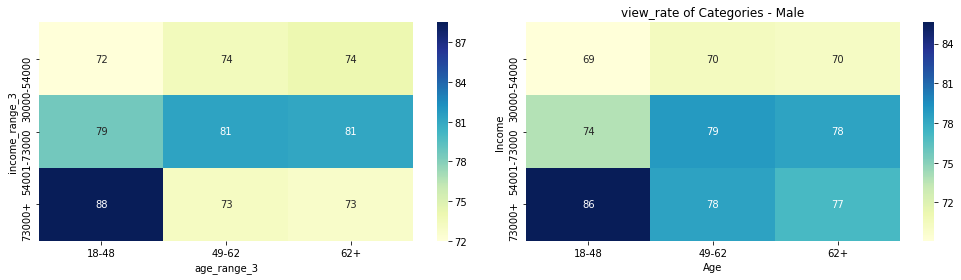

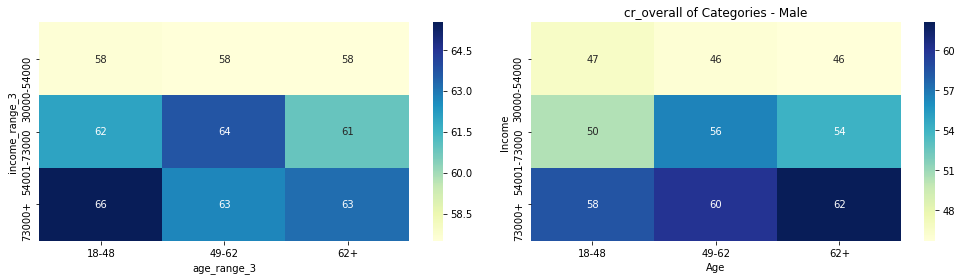

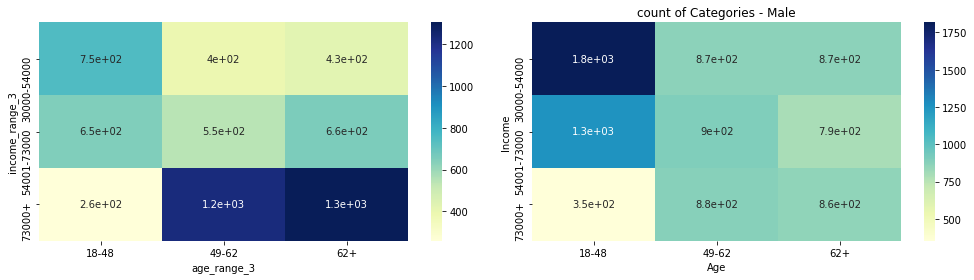

In [57]:
# Let's try all VR, CR and count of people for 3 ranges in each of age and income.
age_income_heat(3,3,'view_rate')
age_income_heat(3,3,'cr_overall')
age_income_heat(3,3,'count')

profile=profile.drop(['age_range_3','income_range_3'],axis=1)    # This line was needed so that we drop the two range fields.
                                                                 # In case we decide to use more ranges these fields will not 
                                                                 # be needed
        
                                                                 # The age and income ranges that will be decided
                                                                 # will be created after examining the heatmaps
    

#### We can see some variations between different categories in both genders as well as in the equivalent categories between the two genders, therefore splitting by 3 ranges in both age and income makes sense.

In [58]:
# We add the two range fields here.
profile=ranges('age',3)
profile=ranges('income',3)
profile.head(10)
   

,age,became_member_on,gender,id,income,age_range,income_range
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,49-62,73000+
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,62+,73000+
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,62+,54001-73000
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,62+,30000-54000
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,49-62,30000-54000
13,61,20170911,F,aa4862eba776480b8bb9c68455b8c2e1,57000.0,49-62,54001-73000
14,26,20140213,M,e12aeaf2d47d42479ea1c4ac3d8286c6,46000.0,18-48,30000-54000
15,62,20160211,F,31dda685af34476cad5bc968bdb01c53,71000.0,49-62,54001-73000
16,49,20141113,M,62cf5e10845442329191fc246e7bcea3,52000.0,49-62,30000-54000
18,57,20171231,M,6445de3b47274c759400cd68131d91b4,42000.0,49-62,30000-54000


In [59]:
 

def dummies(df,var,prefix,drop=False):
    """ Creates dummy variables for all three demographic characteristics (age range, income range and gender)
    Args:
    df: The dataframe (it's going to be profile here)
    var: The variable to be splitted in dummies ('age_range','income_range' or 'gender')
    prefix: The prefix for the new fields created (str)
    drop: If True it will drop the initial variable
    
    Returns:
    The df with the dummies added
    """
    
    # Create the dummies for this variable and drop the first category 
    # Its value can be derived from the values of the other categories (0 or 1)
    dummy = pd.get_dummies(df[var],prefix=prefix,drop_first=True)

    # Concatenate the dummy variables with the original DataFrame
    df=pd.concat([df, dummy], axis=1)
    
    # Drop the initial variable if no longer needed
    if drop:
        df.drop(var,axis=1,inplace=True)
    
    return df

    

In [60]:
# Create all dummy variables
profile=dummies(profile,'age_range','age')
profile=dummies(profile,'gender','gender')
profile=dummies(profile,'income_range','income')
profile.head(10)

,age,became_member_on,gender,id,income,age_range,income_range,age_49-62,age_62+,gender_M,income_54001-73000,income_73000+
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,49-62,73000+,1,0,0,0,1
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,62+,73000+,0,1,0,0,1
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,62+,54001-73000,0,1,1,1,0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,62+,30000-54000,0,1,1,0,0
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,49-62,30000-54000,1,0,1,0,0
13,61,20170911,F,aa4862eba776480b8bb9c68455b8c2e1,57000.0,49-62,54001-73000,1,0,0,1,0
14,26,20140213,M,e12aeaf2d47d42479ea1c4ac3d8286c6,46000.0,18-48,30000-54000,0,0,1,0,0
15,62,20160211,F,31dda685af34476cad5bc968bdb01c53,71000.0,49-62,54001-73000,1,0,0,1,0
16,49,20141113,M,62cf5e10845442329191fc246e7bcea3,52000.0,49-62,30000-54000,1,0,1,0,0
18,57,20171231,M,6445de3b47274c759400cd68131d91b4,42000.0,49-62,30000-54000,1,0,1,0,0


In [61]:
# Create category names (e.g. category 1, category 2)

# Create and sort unique values for the 3 demographic variables together
profile_categ=profile[['age_range','income_range','gender']].drop_duplicates()
profile_categ=profile_categ.sort_values(by=['age_range','income_range','gender']).reset_index().drop('index',axis=1)

# Create category names
profile_categ=profile_categ.reset_index()
profile_categ['index']='Category '+(profile_categ['index']+1).astype(str)

# Rename the new column to category
profile_categ = profile_categ.rename(columns={'index': 'category'})
profile_categ.head(10)

,category,age_range,income_range,gender
0,Category 1,18-48,30000-54000,F
1,Category 2,18-48,30000-54000,M
2,Category 3,18-48,54001-73000,F
3,Category 4,18-48,54001-73000,M
4,Category 5,18-48,73000+,F
5,Category 6,18-48,73000+,M
6,Category 7,49-62,30000-54000,F
7,Category 8,49-62,30000-54000,M
8,Category 9,49-62,54001-73000,F
9,Category 10,49-62,54001-73000,M


In [62]:
# Add category to profile df - This is the complete profile dataset
profile_cat_add=pd.merge(profile,profile_categ,on=['age_range','income_range','gender'])
profile_cat_add.head()

,age,became_member_on,gender,id,income,age_range,income_range,age_49-62,age_62+,gender_M,income_54001-73000,income_73000+,category
0,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,49-62,73000+,1,0,0,0,1,Category 11
1,56,20180428,F,d058f73bf8674a26a95227db098147b1,88000.0,49-62,73000+,1,0,0,0,1,Category 11
2,54,20170207,F,57dd18ec5ddc46828afb81ec5977bef2,80000.0,49-62,73000+,1,0,0,0,1,Category 11
3,53,20161231,F,3a1242dda16248728e350c4bdeb21972,117000.0,49-62,73000+,1,0,0,0,1,Category 11
4,61,20171110,F,fb98ebe9e3e14afaa5b5db182b00b7ec,112000.0,49-62,73000+,1,0,0,0,1,Category 11


In [63]:
# No blank values here
profile_cat_add.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14820 entries, 0 to 14819
Data columns (total 13 columns):
age                   14820 non-null int64
became_member_on      14820 non-null int64
gender                14820 non-null object
id                    14820 non-null object
income                14820 non-null float64
age_range             14820 non-null category
income_range          14820 non-null category
age_49-62             14820 non-null uint8
age_62+               14820 non-null uint8
gender_M              14820 non-null uint8
income_54001-73000    14820 non-null uint8
income_73000+         14820 non-null uint8
category              14820 non-null object
dtypes: category(2), float64(1), int64(2), object(3), uint8(5)
memory usage: 912.0+ KB


In [ ]:
# Add the complete profile dataset to the latest version of transcript df.
# This will provide the final transcript table - ready to apply models.

transcript_final=pd.merge(transcript_all_targ,profile_cat_add,left_on='person',right_on='id').drop('id',axis=1)

In [64]:
pd.set_option('display.max_columns', None)

transcript_final.head(8)

,person,offer_1_cr,offer_2_cr,offer_3_cr,offer_4_cr,offer_5_cr,offer_6_cr,offer_7_cr,offer_8_cr,offer_9_cr,offer_10_cr,view_rate,non_offer_daily_spending,age,became_member_on,gender,income,age_range,income_range,age_49-62,age_62+,gender_M,income_54001-73000,income_73000+,category
0,0009655768c64bdeb2e877511632db8f,NaN,NaN,100.0,NaN,NaN,NaN,0.0,100.0,0.0,0.0,80.0,8.24,33,20170421,M,72000.0,18-48,54001-73000,0,0,1,1,0,Category 4
1,0011e0d4e6b944f998e987f904e8c1e5,NaN,NaN,0.0,100.0,100.0,100.0,NaN,0.0,NaN,NaN,100.0,5.20,40,20180109,M,57000.0,18-48,54001-73000,0,0,1,1,0,Category 4
2,0020c2b971eb4e9188eac86d93036a77,0.0,100.0,NaN,NaN,NaN,NaN,100.0,0.0,NaN,NaN,60.0,6.58,59,20160304,F,90000.0,49-62,73000+,1,0,0,0,1,Category 11
3,0020ccbbb6d84e358d3414a3ff76cffd,NaN,NaN,NaN,100.0,NaN,100.0,NaN,100.0,100.0,NaN,100.0,7.33,24,20161111,F,60000.0,18-48,54001-73000,0,0,0,1,0,Category 3
4,003d66b6608740288d6cc97a6903f4f0,NaN,NaN,100.0,NaN,0.0,NaN,100.0,100.0,NaN,NaN,80.0,1.29,26,20170621,F,73000.0,18-48,54001-73000,0,0,0,1,0,Category 3
5,00426fe3ffde4c6b9cb9ad6d077a13ea,NaN,NaN,NaN,NaN,0.0,NaN,100.0,100.0,NaN,0.0,40.0,0.93,19,20160809,F,65000.0,18-48,54001-73000,0,0,0,1,0,Category 3
6,004b041fbfe44859945daa2c7f79ee64,NaN,NaN,0.0,NaN,NaN,NaN,100.0,NaN,100.0,NaN,66.7,5.57,55,20180508,F,74000.0,49-62,73000+,1,0,0,0,1,Category 11
7,004c5799adbf42868b9cff0396190900,0.0,NaN,NaN,NaN,NaN,NaN,50.0,NaN,100.0,NaN,80.0,20.04,54,20160331,M,99000.0,49-62,73000+,1,0,1,0,1,Category 12


In [65]:
# Let's visualise non-offer spending data before going further
# This is our last target variable

# Create sum of this spending by category
aggr_non_off=transcript_final.groupby('category')['non_offer_daily_spending'].sum().reset_index(name='Sum')

# Create an order field (effectively the number assigned to each category). Useful for ordering by category number
# Sort the aggr table then
aggr_non_off['order']=aggr_non_off['category'].apply(lambda x: x.split()[1]).astype(int)
aggr_non_off=aggr_non_off.sort_values(by='order').drop('order',axis=1).reset_index()

aggr_non_off.drop('index',axis=1,inplace=True)

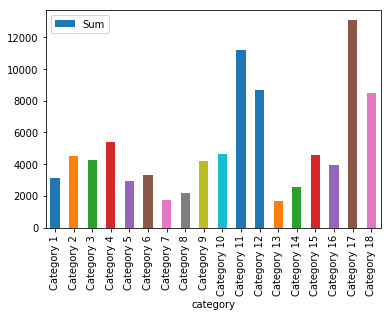

In [66]:
# Bar chart for sum of spending
# There is definitely some variation by category
aggr_non_off.plot('category','Sum',kind='bar')

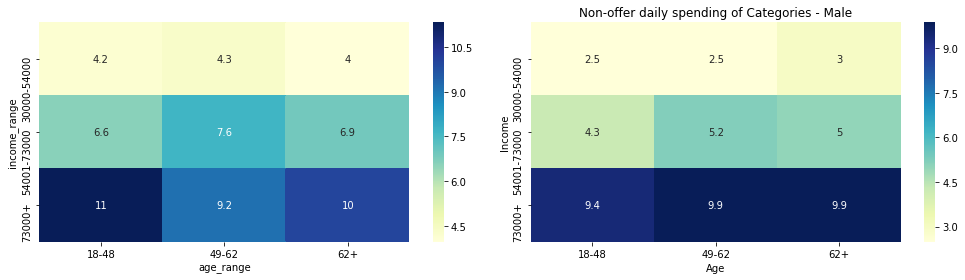

In [67]:
# Let's create similar with above heatmaps for this spending

# Average spending for each category
non_off_spend=transcript_final.groupby(['age_range','income_range','gender'])['non_offer_daily_spending'].mean().reset_index(name='non_offer_daily_spending')

# Split by gender
non_off_spend_f=non_off_spend[non_off_spend.gender=='F']
non_off_spend_m=non_off_spend[non_off_spend.gender=='M']
    
# Create two-way tables
pivot_table_f = non_off_spend_f.pivot_table(index='income_range', columns='age_range', values='non_offer_daily_spending')
pivot_table_m = non_off_spend_m.pivot_table(index='income_range', columns='age_range', values='non_offer_daily_spending')


# Create space for two heatmaps
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Females' heatmap
sns.heatmap(pivot_table_f, annot=True, cmap='YlGnBu',ax=axes[0])

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Income')
plt.title('Non-offer daily spending of Categories - Female')

# Males' heatmap
sns.heatmap(pivot_table_m, annot=True, cmap='YlGnBu',ax=axes[1])

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Income')
plt.title('Non-offer daily spending of Categories - Male')

plt.tight_layout()

plt.show()
    


#### It seems that higher incomes lead to higher spending. 
#### We can't derive safe inferences for spending by age but there is definitely some variation by category and by gender: Female customers  spend more. 

In [68]:
# We noticed earlier that in all offer types we had a CR for about 5000-5500 people
# as the rest of them had not received that specific offer.
# Since we have 18 categories we can tackle this issue by calculating the mean CR by category for each
# of the offer types and fill the NaN with this value.
# This will allow the models below to train and test on 3 times the data currently available
# while maintaining the balance in the dataset since these values represent the average CR of the category

# This is what the code below achieves

target_off_cr=['offer_1_cr','offer_2_cr','offer_3_cr','offer_4_cr','offer_5_cr','offer_6_cr','offer_7_cr','offer_8_cr','offer_9_cr','offer_10_cr']

for offer in target_off_cr:
    mean_offer_cr_by_category = transcript_final.groupby('category')[offer].mean()

    # Fill NaN values in column offer with the corresponding mean value based on column category
    transcript_final[offer] = transcript_final[offer].fillna(transcript_final['category'].map(mean_offer_cr_by_category))


In [69]:
transcript_final.head(8)

,person,offer_1_cr,offer_2_cr,offer_3_cr,offer_4_cr,offer_5_cr,offer_6_cr,offer_7_cr,offer_8_cr,offer_9_cr,offer_10_cr,view_rate,non_offer_daily_spending,age,became_member_on,gender,income,age_range,income_range,age_49-62,age_62+,gender_M,income_54001-73000,income_73000+,category
0,0009655768c64bdeb2e877511632db8f,28.924649,29.263158,100.000000,29.333333,17.478814,58.913934,0.000000,100.000000,0.000000,0.000000,80.0,8.24,33,20170421,M,72000.0,18-48,54001-73000,0,0,1,1,0,Category 4
1,0011e0d4e6b944f998e987f904e8c1e5,28.924649,29.263158,0.000000,100.000000,100.000000,100.000000,57.721803,0.000000,45.638085,30.042463,100.0,5.20,40,20180109,M,57000.0,18-48,54001-73000,0,0,1,1,0,Category 4
2,0020c2b971eb4e9188eac86d93036a77,0.000000,100.000000,27.422907,34.259111,23.788546,68.856144,100.000000,0.000000,60.572907,34.814889,60.0,6.58,59,20160304,F,90000.0,49-62,73000+,1,0,0,0,1,Category 11
3,0020ccbbb6d84e358d3414a3ff76cffd,52.741991,54.270833,35.569106,100.000000,23.672566,100.000000,68.257261,100.000000,100.000000,36.475410,100.0,7.33,24,20161111,F,60000.0,18-48,54001-73000,0,0,0,1,0,Category 3
4,003d66b6608740288d6cc97a6903f4f0,52.741991,54.270833,100.000000,33.935743,0.000000,64.131939,100.000000,100.000000,61.253419,36.475410,80.0,1.29,26,20170621,F,73000.0,18-48,54001-73000,0,0,0,1,0,Category 3
5,00426fe3ffde4c6b9cb9ad6d077a13ea,52.741991,54.270833,35.569106,33.935743,0.000000,64.131939,100.000000,100.000000,61.253419,0.000000,40.0,0.93,19,20160809,F,65000.0,18-48,54001-73000,0,0,0,1,0,Category 3
6,004b041fbfe44859945daa2c7f79ee64,52.985714,62.093256,0.000000,34.259111,23.788546,68.856144,100.000000,33.954244,100.000000,34.814889,66.7,5.57,55,20180508,F,74000.0,49-62,73000+,1,0,0,0,1,Category 11
7,004c5799adbf42868b9cff0396190900,0.000000,56.046646,35.098235,42.627378,28.783621,67.647059,50.000000,36.520376,100.000000,41.846154,80.0,20.04,54,20160331,M,99000.0,49-62,73000+,1,0,1,0,1,Category 12


In [70]:
# No more null values
transcript_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14820 entries, 0 to 14819
Data columns (total 25 columns):
person                      14820 non-null object
offer_1_cr                  14820 non-null float64
offer_2_cr                  14820 non-null float64
offer_3_cr                  14820 non-null float64
offer_4_cr                  14820 non-null float64
offer_5_cr                  14820 non-null float64
offer_6_cr                  14820 non-null float64
offer_7_cr                  14820 non-null float64
offer_8_cr                  14820 non-null float64
offer_9_cr                  14820 non-null float64
offer_10_cr                 14820 non-null float64
view_rate                   14820 non-null float64
non_offer_daily_spending    14820 non-null float64
age                         14820 non-null int64
became_member_on            14820 non-null int64
gender                      14820 non-null object
income                      14820 non-null float64
age_range                   14

### Implementation

In [71]:
# Split between target (y) and explanatory variables (X)
X=transcript_final[['age_49-62','age_62+','gender_M','income_54001-73000','income_73000+','category']]
y=transcript_final[['offer_1_cr','offer_2_cr','offer_3_cr','offer_4_cr','offer_5_cr','offer_6_cr','offer_7_cr','offer_8_cr','offer_9_cr','offer_10_cr','view_rate','non_offer_daily_spending']]

In [72]:
# Split in training and testing dataset
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=55)

In [73]:
#TESTING IF ALL CATEGORIES ARE ROUGHLY 70-30

indices=X_train.index.tolist()

categories_sub=transcript_final.loc[indices].groupby('category').size().reset_index(name='count_sub')

categories_all=transcript_final.groupby('category').size().reset_index(name='count_all')

categories_merge=pd.merge(categories_sub,categories_all,on='category')

categories_merge['prop']=categories_merge.count_sub/categories_merge.count_all

print('Minimum proportion: ',categories_merge.prop.min())
print('Maximum proportion: ',categories_merge.prop.max())

Minimum proportion:  0.669491525424
Maximum proportion:  0.71686746988


In [74]:
# Category was used for the train-test split but no longer needed

X_train.drop('category',axis=1,inplace=True)
X_test.drop('category',axis=1,inplace=True)

In [75]:
def r_squared(y_pred,y_act):
    """ Calculates the performance metric for a single target variable. Both the actual and the predicted
        values are aggregated by category and the average is taken. Then the function returns the R squared
        of these average values. It can be used both for the test and the training set.
        
        Args:
        y_pred: An array of the predicted values
        y_act: A series of the actual values (from y_test or y_train) 
    
        Returns:
        The score assigned to the target variable
    """
    
    # Convert y_pred to a df so that each value is assigned to the index of the actual value
    pred = pd.DataFrame({'index': y_act.index, 'prediction': y_pred})
    
    # Merge the predictions DataFrame with the original dataset
    pred_add_cat = pd.merge(transcript_final.loc[y_act.index], pred, left_index=True, right_on='index')
    pred_add_cat.drop('index',axis=1,inplace=True)

    # Aggregate by category and average prediction
    pred_cat_mean=pred_add_cat.groupby('category')['prediction'].mean().reset_index(name='pred_mean')
     
    # Convert actual values to a df    
    act = pd.DataFrame({'actual': y_act})

    # Merge the actuals DataFrame with the original dataset
    act_add_cat=pd.merge(transcript_final.loc[y_act.index],act,left_index=True,right_index=True)
    
    # Aggregate by category and average prediction
    act_cat_mean=act_add_cat.groupby('category')['actual'].mean().reset_index(name='act_mean')
    
    #Calculate the R squared for the average values
    score=r2_score(act_cat_mean['act_mean'], pred_cat_mean['pred_mean'])
    
    return score
    

In [76]:
def r_squared_all(y_act,y_pred):
    """ Calculates the overall performance metric for the target variables using the function above (r_squared)
    for each single one.
    Args: 
    y_act: A dataframe of the actual values of the target variables (y_train or y_test) 
    y_pred: A matrix of the predicted values of the training or test dataset
    Returns:
    The overall R Squared score of the target variables
    """
    # Create an empty list for the individual scores
    scores=[]
    
    #Loop through individual target variables
    for i in range(len(y.columns)):
        # Extract series of individual variable for actual and predicted values
        y_act_feat=y_act[y.columns[i]]
        y_pred_feat=y_pred[:,i]
        
        # Use individual score function and append the score to the list
        scores.append(r_squared(y_pred_feat,y_act_feat))
     
    # Final score to be returned is the mean of individual ones 
    score=np.mean(scores)

    return score

In [77]:
def model_fit(model):
    """ Trains and fits a given model. 
    Args: 
    model: The model to be fitted 
    
    Returns:
    score_ts: R squared score for test dataset
    score_tr: R squared score for training dataset
    y_pred_ts: A matrix of the predicted values of the test dataset
    y_pred_tr: A matrix of the predicted values of the training dataset
    model.get_params(): The parameters used by the model
    """
    
    # Assign and fit the model
    model = model
    model.fit(X_train,y_train)

    # Predict values for test dataset and for training dataset
    y_pred_ts=model.predict(X_test)       
    y_pred_tr=model.predict(X_train)
        
    # Calculate R Squared for test and training dataset    
    score_ts=r_squared_all(y_test,y_pred_ts)
    score_tr=r_squared_all(y_train,y_pred_tr)
    
    # Print scores
    print('Average R^2 for testing set: ',score_ts)
    print('Average R^2 for training set: ',score_tr)

    return score_ts,score_tr,y_pred_ts,y_pred_tr,model.get_params()
  

In [78]:
# Assign initial models
# We will focus on Random Forest Regressor,Gradient Boosting Regressor and Support Vector Regressor
# Multi Output Regressor is used to handle all target variables
# Default parameters are used apart from the random_state that has to be the same as with the datasets split

rfr=MultiOutputRegressor(RandomForestRegressor(random_state=55))

gbr=MultiOutputRegressor(GradientBoostingRegressor(random_state=55))

svr=MultiOutputRegressor(SVR())

In [79]:
# Create a dataframe for comparing models' performance
models_compare=pd.DataFrame()
models_compare['model']=pd.Series(['RandomForestRegressor','GradientBoostingRegressor','SVR'])

In [80]:
# Calculate the score of the test dataset for each of the 3 models created above

print('Random Forest Regressor:')
rfr_default=model_fit(rfr)[0]
print('')

print('Gradient Boosting Regressor:')
gbr_default=model_fit(gbr)[0]
print('')

print('Support Vector Regressor:')
svr_default=model_fit(svr)[0]

Random Forest Regressor:
Average R^2 for testing set:  0.916795634222
Average R^2 for training set:  0.997632259692

Gradient Boosting Regressor:
Average R^2 for testing set:  0.906784982238
Average R^2 for training set:  0.988072716912

Support Vector Regressor:
Average R^2 for testing set:  0.815972014163
Average R^2 for training set:  0.864866907284


#### Some conclusions here:
#### 1. There is still some overfitting here especially in the first two model where training set is almost perfectly predicted. However, the R squared for the testing set is very high anyway so these model satisfactorily predict the behaviour of unseen customers.
#### 2. Support Vector Regressor is not as good in interpretting this data however we can give it a second chance in the cross validation step that follows. Some hyperparameters might significantly change the performance

### Refinement

#### As per point 1 above there is no particular reason for refinement since R Squared is greater than 90% for two of the models which is very good as a start anyway. Previous implementation with target variables that had missing values gave an R Squared of around 60% and much higher overfitting (remember that in all offers there were around 5500 of 14820 non-null values. Further implementation with filled NaN values and 4 age and income ranges returned a performance metric of roughly 89% - a bit lower than current model - so the dataset was refined from the beginning to ensure high performance.     

### Model Evaluation and Validation

In [81]:
# Add the performance of the default models to the compare table
models_compare['default']=pd.Series([rfr_default,gbr_default,svr_default])


#### A function for cross-validation will be created here

In [82]:
def hyper_tune(model,parameters):
    
    """ Tunes the hyperparameters for a given model using Grid Search Cross-Validation. 
    Args: 
    model: The model to be tuned 
    parameters: The set of hypermarameters that will be passed to the grid
    Returns:
    cv.best_params_: The parameters that gave the highest score
    cv.best_estimator_: The model with the whole set of parameters (not just those used for tuning)
    """
    
    # Create a scorer for the grid based on the overall R Squared function created earlier 
    custom_scorer = make_scorer(r_squared_all)
   
    # Pass the model, set of parameters and scorer to the grid
    cv = GridSearchCV(model, param_grid=parameters,scoring=custom_scorer)
    
    # Train and fit the grid
    cv.fit(X_train,y_train)
    y_pred_ts=cv.predict(X_test)        
        
        
    print('Best params: ',cv.best_params_)
    print('')
    print('Best estimator: ',cv.best_estimator_)
       
    return cv.best_params_,cv.best_estimator_

In [83]:
# Default parameters for Random Forest Regressor
rfr.get_params()

{'estimator__bootstrap': True,
 'estimator__criterion': 'mse',
 'estimator__max_depth': None,
 'estimator__max_features': 'auto',
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_impurity_split': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 10,
 'estimator__n_jobs': 1,
 'estimator__oob_score': False,
 'estimator__random_state': 55,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=55, verbose=0, warm_start=False),
 'n_jobs': 1}

In [84]:
# Let's try max_feature and n_estimators
parameters= {
       
      'estimator__max_features':['auto',3,5],
      'estimator__n_estimators':[10,100,200], 
      'estimator__random_state':[55] 
    }


# Assign the model with the optimal parameters to best_rfr to be used later on

best_rfr=hyper_tune(rfr,parameters)[1]

Best params:  {'estimator__max_features': 'auto', 'estimator__n_estimators': 200, 'estimator__random_state': 55}

Best estimator:  MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=55, verbose=0, warm_start=False),
           n_jobs=1)


#### It seems that the higher the n_estimators the better the model

In [85]:
# Retrain the model with the optimal parameters
# Testing R Squared is higher now
rfr_improved=model_fit(best_rfr)[0]

Average R^2 for testing set:  0.919594618538
Average R^2 for training set:  0.999873081972


#### The model gained some performance: 0.919-0.916=0.003 or 0.3%

In [86]:
# Parameters for Gradient Boosting Regressor
gbr.get_params()

{'estimator__alpha': 0.9,
 'estimator__criterion': 'friedman_mse',
 'estimator__init': None,
 'estimator__learning_rate': 0.1,
 'estimator__loss': 'ls',
 'estimator__max_depth': 3,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_impurity_split': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__presort': 'auto',
 'estimator__random_state': 55,
 'estimator__subsample': 1.0,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
              max_leaf_nodes=None, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_

In [87]:
# Let's try a few parameters here
parameters= {
      'estimator__learning_rate':[0.1,0.3],
      'estimator__alpha':[0.9,0.7],
      'estimator__n_estimators':[50,100], 
      'estimator__random_state':[55] 
    }

# Assign the model with the optimal parameters to best_gbr 

best_gbr=hyper_tune(gbr,parameters)[1]

Best params:  {'estimator__alpha': 0.9, 'estimator__learning_rate': 0.3, 'estimator__n_estimators': 50, 'estimator__random_state': 55}

Best estimator:  MultiOutputRegressor(estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.3, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=50, presort='auto', random_state=55,
             subsample=1.0, verbose=0, warm_start=False),
           n_jobs=1)


#### It seems that less estimators (50 vs 100) and higher learning rate (0.3 vs 0.1) increased the performance 
#### Let's see by how


In [88]:

gbr_improved=model_fit(best_gbr)[0]

Average R^2 for testing set:  0.91267840656
Average R^2 for training set:  0.994898236736


#### The refined model gained 91.27%-90.67%=0.6%
#### Let's see if other parameters could have boosted it further

In [89]:
# Let's try max_depth,max_features and min_samples_split
parameters= {
      'estimator__max_depth': [3,5],
      'estimator__max_features': [None,3,5],
      'estimator__min_samples_split': [2,3],
      'estimator__random_state':[55] 
    }

# Assign the model with the optimal parameters to best_rbr 

best_gbr_alt=hyper_tune(gbr,parameters)[1]

Best params:  {'estimator__max_depth': 3, 'estimator__max_features': 3, 'estimator__min_samples_split': 2, 'estimator__random_state': 55}

Best estimator:  MultiOutputRegressor(estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=3,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=55,
             subsample=1.0, verbose=0, warm_start=False),
           n_jobs=1)


In [90]:

gbr_improved_alt=model_fit(best_gbr_alt)[0]

Average R^2 for testing set:  0.905741887051
Average R^2 for training set:  0.988258710904


#### The default parameters and roughly the initial performance were returned


In [91]:
# What about SVR finally?
svr.get_params()

{'estimator__C': 1.0,
 'estimator__cache_size': 200,
 'estimator__coef0': 0.0,
 'estimator__degree': 3,
 'estimator__epsilon': 0.1,
 'estimator__gamma': 'auto',
 'estimator__kernel': 'rbf',
 'estimator__max_iter': -1,
 'estimator__shrinking': True,
 'estimator__tol': 0.001,
 'estimator__verbose': False,
 'estimator': SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
   kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
 'n_jobs': 1}

In [92]:
# Let's try C,kernel and gamma
parameters= {
      'estimator__C':[0.8,1],
      'estimator__kernel':['linear','rbf'],
      'estimator__gamma': ['auto',0.1]
        }

best_svr=hyper_tune(svr,parameters)[1]

Best params:  {'estimator__C': 1, 'estimator__gamma': 'auto', 'estimator__kernel': 'rbf'}

Best estimator:  MultiOutputRegressor(estimator=SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
           n_jobs=1)


In [93]:
svr_improved=model_fit(best_svr)[0]

Average R^2 for testing set:  0.815972014163
Average R^2 for training set:  0.864866907284


#### No improvement here - The default parameters and roughly the initial performance were returned

In [94]:
# Assign final performance to the compare table
models_compare['improved']=pd.Series([rfr_improved,gbr_improved,svr_improved])

In [95]:
# Compare table completed
models_compare

,model,default,improved
0,RandomForestRegressor,0.916796,0.919595
1,GradientBoostingRegressor,0.906785,0.912678
2,SVR,0.815972,0.815972


#### Finally, let's take a look at the predictions the optimal model has created for each category and target variable.

In [97]:
# Train the RFR with the optimal parameters - Extract the predictions for the test set
y_pred_opt=model_fit(best_rfr)[2]

Average R^2 for testing set:  0.919594618538
Average R^2 for training set:  0.999873081972


In [109]:
y_pred_opt

array([[ 25.19409155,  17.30165014,  25.71456259, ...,  19.01543484,
         69.03739549,   2.53538292],
       [ 45.23169824,  56.17521399,  36.75406608, ...,  41.2719473 ,
         78.77230685,   9.70161566],
       [ 52.23224754,  61.11778641,  27.50100706, ...,  34.78349434,
         73.27412292,   9.24039108],
       ..., 
       [ 32.41344215,  36.54072195,  30.74130331, ...,  34.11764042,
         78.55541364,   5.04254986],
       [ 36.89365237,  38.4633756 ,  40.70956223, ...,  41.57950573,
         79.21396696,   5.19366189],
       [ 40.97602513,  36.06274789,  30.31530697, ...,  31.23364613,
         76.43702379,   3.79380762]])

In [150]:
 
# Create dataframe with categories only
predictions=pd.DataFrame({'category':pd.Series(transcript_final.category.unique())})

# Join the predictions matrix back to the test set indices. That will be done for each variable separately
for i in range(len(y.columns)):
    # Predictions for the variable assigned to the right index
    pred = pd.DataFrame({'index': y_test.index, 'prediction': y_pred_opt[:,i]})
    # Merge transcript table with predictions so that category and predictions are in the same place
    pred_add_cat = pd.merge(transcript_final.loc[y_test.index], pred, left_index=True, right_on='index')
    pred_add_cat.drop('index',axis=1,inplace=True)
    # Aggregate by category - calculate the average prediction
    pred_cat_mean=pred_add_cat.groupby('category')['prediction'].mean().reset_index(name=y.columns[i])
    # Append predictions for this variable to the previously created table with categories
    predictions=pd.merge(predictions,pred_cat_mean,on='category')

# Sort by category number
predictions['order']=predictions['category'].apply(lambda x: x.split()[1]).astype(int)
predictions=predictions.sort_values(by='order').drop('order',axis=1).reset_index()
predictions.drop('index',axis=1,inplace=True)
# Set category as index so that a heatmap can be created
predictions.set_index('category',inplace=True)
predictions.head()


,offer_1_cr,offer_2_cr,offer_3_cr,offer_4_cr,offer_5_cr,offer_6_cr,offer_7_cr,offer_8_cr,offer_9_cr,offer_10_cr,view_rate,non_offer_daily_spending
category,,,,,,,,,,,,
Category 1,44.125403,40.324733,28.379366,28.835377,16.243518,62.192052,69.309695,62.994234,52.551394,30.298500,72.080781,4.335200
Category 2,25.194092,17.301650,25.714563,23.087663,10.575550,57.137498,56.101476,59.650925,38.105803,19.015435,69.037395,2.535383
Category 3,52.448585,54.622354,35.436207,34.285791,24.850369,65.381480,68.371184,58.434849,61.607891,37.666330,80.241398,6.636977
Category 4,29.263494,28.587844,30.447612,28.696349,16.836667,58.114808,58.101728,58.170172,44.854813,29.882743,74.156424,4.157370
Category 5,57.869234,69.578114,42.606981,58.349910,46.385403,70.754966,77.027389,49.057767,57.174782,52.835995,88.669170,11.583270


In [151]:
# First 11 target variables range between 0 and 100 but non-offer spending can be any number
# In fact all values are much smaller than 100.
# This variable has to be normalised in order to have the same range as the others before being added to the heatmap

spending=predictions.non_offer_daily_spending
normalized_spending = (spending - spending.min()) / (spending.max() - spending.min()) * 100
predictions.non_offer_daily_spending=normalized_spending
predictions.head()

,offer_1_cr,offer_2_cr,offer_3_cr,offer_4_cr,offer_5_cr,offer_6_cr,offer_7_cr,offer_8_cr,offer_9_cr,offer_10_cr,view_rate,non_offer_daily_spending
category,,,,,,,,,,,,
Category 1,44.125403,40.324733,28.379366,28.835377,16.243518,62.192052,69.309695,62.994234,52.551394,30.298500,72.080781,20.946037
Category 2,25.194092,17.301650,25.714563,23.087663,10.575550,57.137498,56.101476,59.650925,38.105803,19.015435,69.037395,1.315618
Category 3,52.448585,54.622354,35.436207,34.285791,24.850369,65.381480,68.371184,58.434849,61.607891,37.666330,80.241398,46.051288
Category 4,29.263494,28.587844,30.447612,28.696349,16.836667,58.114808,58.101728,58.170172,44.854813,29.882743,74.156424,19.006461
Category 5,57.869234,69.578114,42.606981,58.349910,46.385403,70.754966,77.027389,49.057767,57.174782,52.835995,88.669170,100.000000


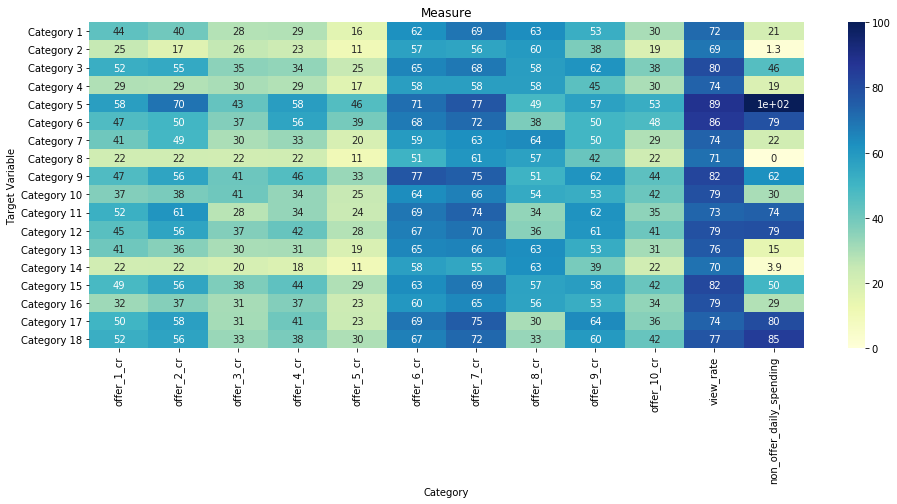

In [156]:
# Let's create the heatmap then

# Create a figure with subplots
fig, ax = plt.subplots(figsize=(16, 6))

# Plot the heatmap on the specified subplot
sns.heatmap(predictions, annot=True, cmap='YlGnBu')

# Add labels and title
plt.xlabel('Category')
plt.ylabel('Target Variable')
plt.title('Measure')


plt.show()

### Some inference here:

#### 1. Categories 5,17 and 18 tend to spend a lot anyway so they don't need to be sent offers as this would mean they will get a reward for something they would buy anyway
#### 2. Offers 6 and 7 are the most succesfull ones followed by offers 8 and 9.
#### 3. View rate generally high for all categories